In [1]:
# ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º importÌï©ÎãàÎã§.
import sys
# ÌååÏù¥ÌÜ†Ïπò
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from torch.utils.data import Dataset, DataLoader 
#!pip install -q sktime
from tqdm import tqdm
import xgboost as xgb
import pandas as pd
import numpy as np
from datetime import datetime
import math
import os
from xgboost import XGBRegressor
import platform
import optuna
from sktime.forecasting.model_selection import temporal_train_test_split

device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

# ÎûúÎç§ ÏãúÎìúÎ•º ÏÑ§Ï†ïÌï©ÎãàÎã§. Ïù¥Î†áÍ≤å ÌïòÎ©¥ ÏΩîÎìúÎ•º Îã§Ïãú Ïã§ÌñâÌï† ÎïåÎèÑ Í∞ôÏùÄ Í≤∞Í≥ºÎ•º ÏñªÏùÑ Ïàò ÏûàÏäµÎãàÎã§.
np.random.seed(42)

# ÌòÑÏû¨ ÏÇ¨Ïö©ÌïòÍ≥† ÏûàÎäî ÎùºÏù¥Î∏åÎü¨Î¶¨Ïùò Î≤ÑÏ†ÑÏùÑ Ï∂úÎ†•Ìï©ÎãàÎã§.
print("Python version:", sys.version)
print("xgboost version:", xgb.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("optuna version:", optuna.__version__)

Python version: 3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ]
xgboost version: 2.0.0
pandas version: 1.5.3
numpy version: 1.22.3
optuna version: 3.3.0


# Îç∞Ïù¥ÌÑ∞ Í∏∞Î≥∏ Í¥ÄÏ∞∞

In [2]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
train_data = pd.read_csv('open/train.csv')
test_data = pd.read_csv('open/test.csv')
build_data = pd.read_csv('open/building_info.csv')

In [3]:
train_data.head()

num_date_time  Í±¥Î¨ºÎ≤àÌò∏           ÏùºÏãú  Í∏∞Ïò®(C)  Í∞ïÏàòÎüâ(mm)  ÌíçÏÜç(m/s)  ÏäµÎèÑ(%)  ÏùºÏ°∞(hr)  \
0  1_20220601 00     1  20220601 00   18.6      NaN      0.9   42.0     NaN   
1  1_20220601 01     1  20220601 01   18.0      NaN      1.1   45.0     NaN   
2  1_20220601 02     1  20220601 02   17.7      NaN      1.5   45.0     NaN   
3  1_20220601 03     1  20220601 03   16.7      NaN      1.4   48.0     NaN   
4  1_20220601 04     1  20220601 04   18.4      NaN      2.8   43.0     NaN   

   ÏùºÏÇ¨(MJ/m2)  Ï†ÑÎ†•ÏÜåÎπÑÎüâ(kWh)  
0        NaN     1085.28  
1        NaN     1047.36  
2        NaN      974.88  
3        NaN      953.76  
4        NaN      986.40

In [4]:
test_data.head()

num_date_time  Í±¥Î¨ºÎ≤àÌò∏           ÏùºÏãú  Í∏∞Ïò®(C)  Í∞ïÏàòÎüâ(mm)  ÌíçÏÜç(m/s)  ÏäµÎèÑ(%)
0  1_20220825 00     1  20220825 00   23.5      0.0      2.2     72
1  1_20220825 01     1  20220825 01   23.0      0.0      0.9     72
2  1_20220825 02     1  20220825 02   22.7      0.0      1.5     75
3  1_20220825 03     1  20220825 03   22.1      0.0      1.3     78
4  1_20220825 04     1  20220825 04   21.8      0.0      1.0     77

In [6]:
# ÌïúÍ∏ÄÏùÄ Íπ®ÏßêÌòÑÏÉÅÏù¥ ÏûàÏñ¥ Ïª¨ÎüºÏù¥Î¶Ñ ÏòÅÏñ¥Î°ú Î≥ÄÍ≤Ω
train_data = train_data.rename(columns={
    'Í±¥Î¨ºÎ≤àÌò∏': 'building_number',
    'ÏùºÏãú': 'date_time',
    'Í∏∞Ïò®(C)': 'temperature',
    'Í∞ïÏàòÎüâ(mm)': 'rainfall',
    'ÌíçÏÜç(m/s)': 'windspeed',
    'ÏäµÎèÑ(%)': 'humidity',
    'ÏùºÏ°∞(hr)': 'sunshine',
    'ÏùºÏÇ¨(MJ/m2)': 'solar_radiation',
    'Ï†ÑÎ†•ÏÜåÎπÑÎüâ(kWh)': 'power_consumption'
})
test_data = test_data.rename(columns={
    'Í±¥Î¨ºÎ≤àÌò∏': 'building_number',
    'ÏùºÏãú': 'date_time',
    'Í∏∞Ïò®(C)': 'temperature',
    'Í∞ïÏàòÎüâ(mm)': 'rainfall',
    'ÌíçÏÜç(m/s)': 'windspeed',
    'ÏäµÎèÑ(%)': 'humidity',
    'ÏùºÏ°∞(hr)': 'sunshine',
    'ÏùºÏÇ¨(MJ/m2)': 'solar_radiation',
    'Ï†ÑÎ†•ÏÜåÎπÑÎüâ(kWh)': 'power_consumption'
})
build_data = build_data.rename(columns={
    'Í±¥Î¨ºÎ≤àÌò∏': 'building_number',
    'Í±¥Î¨ºÏú†Ìòï': 'building_type',
    'Ïó∞Î©¥Ï†Å(m2)': 'total_area',
    'ÎÉâÎ∞©Î©¥Ï†Å(m2)': 'cooling_area',
    'ÌÉúÏñëÍ¥ëÏö©Îüâ(kW)': 'solar_power_capacity',
    'ESSÏ†ÄÏû•Ïö©Îüâ(kWh)': 'ess_capacity',
    'PCSÏö©Îüâ(kW)': 'pcs_capacity'
})
translation_dict = {
    'Í±¥Î¨ºÍ∏∞ÌÉÄ': 'Other Buildings',
    'Í≥µÍ≥µ': 'Public',
    'ÎåÄÌïôÍµê': 'University',
    'Îç∞Ïù¥ÌÑ∞ÏÑºÌÑ∞': 'Data Center',
    'Î∞±ÌôîÏ†êÎ∞èÏïÑÏö∏Î†õ': 'Department Store and Outlet',
    'Î≥ëÏõê': 'Hospital',
    'ÏÉÅÏö©': 'Commercial',
    'ÏïÑÌååÌä∏': 'Apartment',
    'Ïó∞Íµ¨ÏÜå': 'Research Institute',
    'ÏßÄÏãùÏÇ∞ÏóÖÏÑºÌÑ∞': 'Knowledge Industry Center',
    'Ìï†Ïù∏ÎßàÌä∏': 'Discount Mart',
    'Ìò∏ÌÖîÎ∞èÎ¶¨Ï°∞Ìä∏': 'Hotel and Resort'
}

build_data['building_type'] = build_data['building_type'].replace(translation_dict)

- testÏóêÎäî train.csvÏôÄ Îã§Î•¥Í≤å `ÏùºÏ°∞, ÏùºÏÇ¨, Ï†ÑÎ†•ÏÜåÎπÑÎüâ`Ïª¨ÎüºÏù¥ ÏóÜÎäî ÏÉÅÌÉú

In [7]:
# Í∞Å Îç∞Ïù¥ÌÑ∞Ïùò Í≤∞Ï∏°Ïπò ÌôïÏù∏
train_missing = train_data.isnull().sum()
test_missing = test_data.isnull().sum()

print("train.csvÏùò Í≤∞Ï∏°Ïπò:\n", train_missing)
print("\ntest.csvÏùò Í≤∞Ï∏°Ïπò:\n", test_missing)

train.csvÏùò Í≤∞Ï∏°Ïπò:
 num_date_time             0
building_number           0
date_time                 0
temperature               0
rainfall             160069
windspeed                19
humidity                  9
sunshine              75182
solar_radiation       87913
power_consumption         0
dtype: int64

test.csvÏùò Í≤∞Ï∏°Ïπò:
 num_date_time      0
building_number    0
date_time          0
temperature        0
rainfall           0
windspeed          0
humidity           0
dtype: int64


- Í≤∞Ï∏°ÏπòÎäî trainÏóêÏÑúÎßå Î∞úÍ≤¨Îê®

In [8]:
build_data.head()

building_number    building_type  total_area  cooling_area  \
0                1  Other Buildings   110634.00      39570.00   
1                2  Other Buildings   122233.47      99000.00   
2                3  Other Buildings   171243.00     113950.00   
3                4  Other Buildings    74312.98      34419.62   
4                5  Other Buildings   205884.00     150000.00   

  solar_power_capacity ess_capacity pcs_capacity  
0                    -            -            -  
1                    -            -            -  
2                   40            -            -  
3                   60            -            -  
4                    -         2557         1000

- Í±¥Î¨ºÏú†Ìòï: ÏÉÅÏóÖÏö©, Ï£ºÍ±∞Ïö©, Í≥µÏû• Îì±Ïùò Í±¥Î¨º Ïú†ÌòïÏóê Îî∞Îùº Ï†ÑÎ†• ÏÜåÎπÑÎüâÏù¥ Îã§Î•º Ïàò ÏûàÏäµÎãàÎã§.
- Ïó∞Î©¥Ï†Å: ÌÅ∞ Í±¥Î¨ºÏùÄ Ï†ÑÎ†• ÏÇ¨Ïö©ÎüâÏù¥ ÎßéÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏùÑ Ïàò ÏûàÏäµÎãàÎã§.
- ÎÉâÎ∞©Î©¥Ï†Å: ÎÉâÎ∞©Î©¥Ï†ÅÎèÑ ÎÉâÎ∞© Ïö¥ÏòÅÍ≥º Í¥ÄÎ†®Ïù¥ ÏûàÏñ¥ÏÑú Ï†ÑÎ†• ÏÜåÎπÑÎüâÏóê ÏòÅÌñ•ÏùÑ Ï§Ñ Ïàò ÏûàÏäµÎãàÎã§

In [9]:
train_df = pd.merge(train_data, build_data, on = 'building_number', how = 'left')
test_df = pd.merge(test_data, build_data, on = 'building_number', how = 'left')

 - building_infoÏùò ÌÉúÏñëÍ¥ë, ESS, PCSÎäî ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏùÑ Í≤ÉÏù¥Îùº drop

In [10]:
train_df = train_df.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity'], axis = 1)
test_df = test_df.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity'], axis = 1)

# ÌÉêÏÉâÏ†Å Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù(EDA)

In [11]:
# Ï†ÑÎ∂Ä 22ÎÖÑÏûÑÏúºÎ°ú yearÏùÄ Ï†úÏô∏Ìïú ÌõÑ ÏÉùÏÑ±
train_df['date'] = pd.to_datetime(train_df['date_time'], format = '%Y%m%d %H')

train_df['hour'] = train_df['date'].dt.hour
train_df['day'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month
train_df['week'] = train_df['date'].dt.weekday
test_df['date'] = pd.to_datetime(test_df['date_time'], format='%Y%m%d %H')

test_df['hour'] = test_df['date'].dt.hour
test_df['day'] = test_df['date'].dt.day
test_df['month'] = test_df['date'].dt.month
test_df['week'] = test_df['date'].dt.dayofweek #ÏöîÏùº

In [12]:
# Í±¥Î¨ºÏú†Ìòï ÌôïÏù∏
train_df['building_type'].unique()

array(['Other Buildings', 'Public', 'University', 'Data Center',
       'Department Store and Outlet', 'Hospital', 'Commercial',
       'Apartment', 'Research Institute', 'Knowledge Industry Center',
       'Discount Mart', 'Hotel and Resort'], dtype=object)

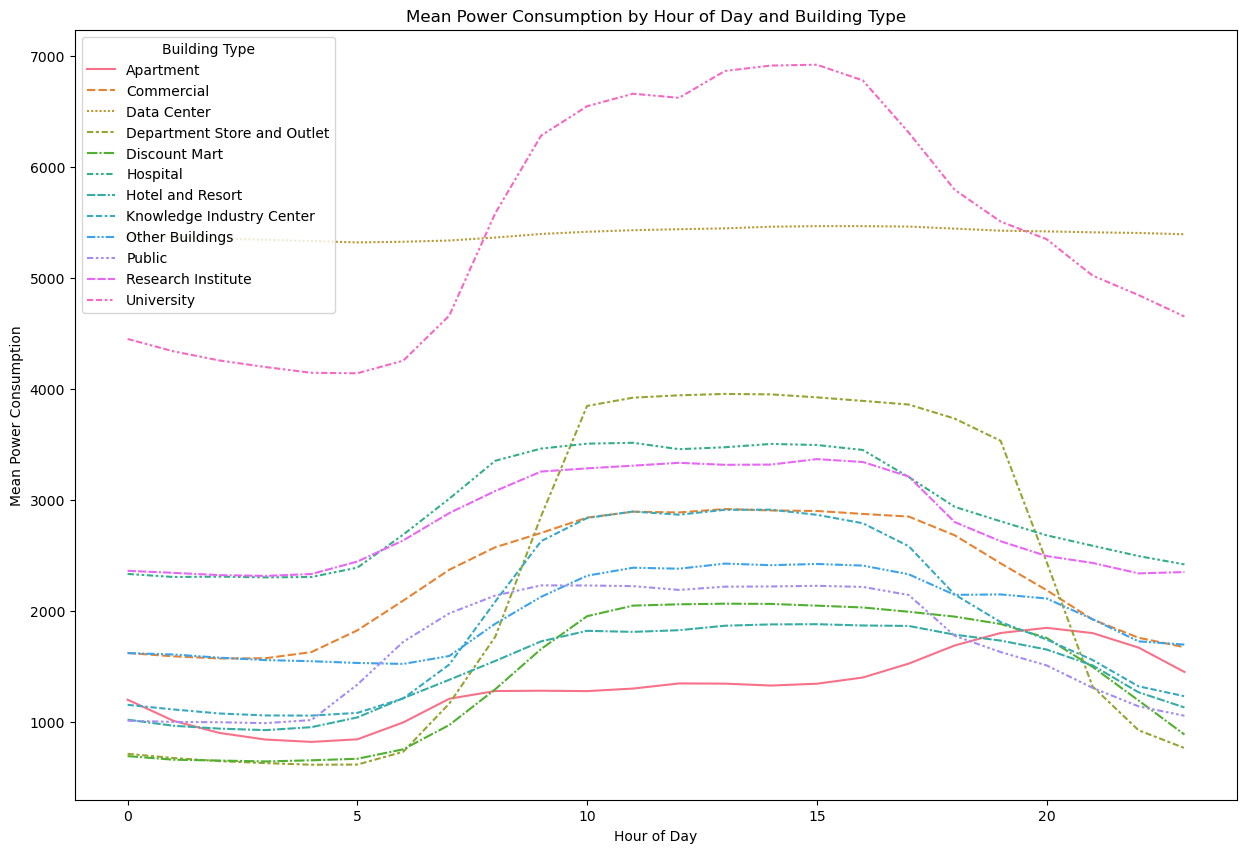

In [13]:
import seaborn as sns

# hour of the day
mean_power_by_hour_building = train_df.groupby(['hour', 'building_type'])['power_consumption'].mean().reset_index()

pivot_df = mean_power_by_hour_building.pivot(index='hour', columns='building_type', values='power_consumption')

plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Hour of Day and Building Type')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.show()

**ÎÇÆÏãúÍ∞ÑÏóê Ï†ÑÎ†•ÏùÑ Í∞ÄÏû• ÎßéÏù¥ ÏÜåÎ™®, dataDenterÏôÄ ApartmentÎßå Ï°∞Í∏à ÏòàÏô∏**

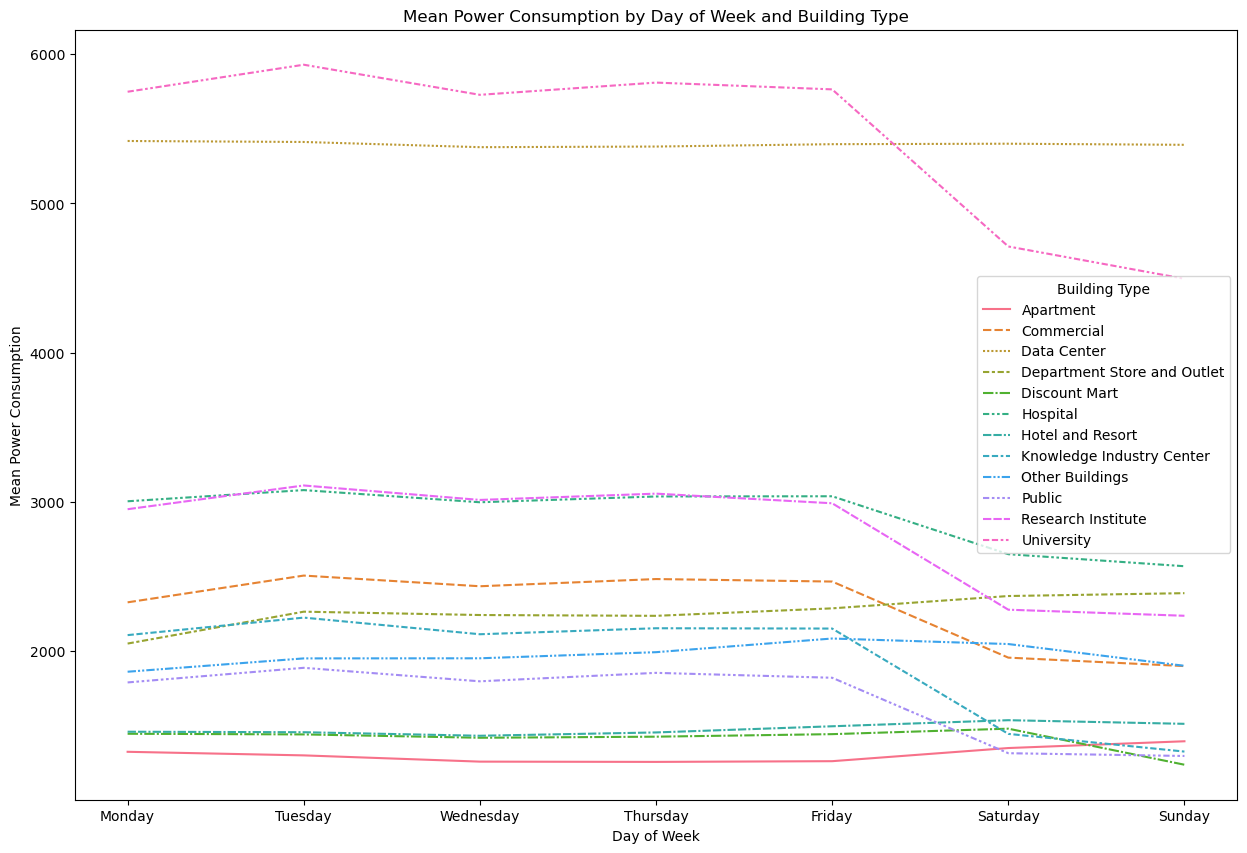

In [19]:
mean_power_by_day_building = train_df.groupby(['week', 'building_type'])['power_consumption'].mean().reset_index()

pivot_df_day = mean_power_by_day_building.pivot(index='week', columns='building_type', values='power_consumption')

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df_day.index = day_names

plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df_day)
plt.title('Mean Power Consumption by Day of Week and Building Type')
plt.xlabel('Day of Week')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.show()

**Ï£ºÎßêÏóî Ï†ÑÎ†•ÏÜåÎπÑÍ∞Ä ÎåÄÏ≤¥Î°ú ÎÇÆÏïÑÏßÄÎäî Ï∂îÏÑ∏Î•º Î≥¥ÏûÑ, datacenter, apartment, hotel and resort, department and outletÏ†úÏô∏**

# Ï†ÑÏ≤òÎ¶¨ ÏΩîÎìú Î∂ÑÏÑù

1. Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
```
# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Î∞è ÌäπÏÑ± Ï∂îÍ∞Ä
def process_data(data, mode):
    # Í≤∞Ï∏°Ïπò ÎåÄÏ≤¥
    data['wind'] = data['wind'].fillna(method='ffill')
    data['hum'] = data['hum'].fillna(method='ffill')
    data = data.fillna(0)

    # ÌäπÏÑ± Ï∂îÍ∞Ä
    data = time_features(data, mode)
    data = side_indicator(data)
    data = temp_features(data)

    # Ï£ºÍ∏∞Ï†ÅÏù∏ ÎÇ†Ïßú Ìå®ÌÑ¥ÏùÑ ÏΩîÏÇ¨Ïù∏Í≥º ÏÇ¨Ïù∏ Ìï®ÏàòÎ°ú Î≥ÄÌôò
    data['summer_cos'] = data['date'].apply(summer_cos)
    data['summer_sin'] = data['date'].apply(summer_sin)

    return data
```

-> ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞Ïùò Í≤ΩÏö∞, Ïù¥Ï†Ñ ÏãúÍ∞ÑÎåÄÏùò Îç∞Ïù¥ÌÑ∞Î°ú Í≤∞Ï∏°ÏπòÎ•º Ï±ÑÏö∞Îäî Í≤ÉÏù¥ Ï¢Ä Îçî Ïò¨Î∞îÎ•∏ Î∞©Î≤ï


- üéØ time_features() ÏΩîÎìúÏóê ÌäπÏ†ïÌïú Í±¥Î¨ºÎì§Ïóê ÎåÄÌïòÏó¨ Ï≤òÎ¶¨Ìïú Î∂ÄÎ∂ÑÏóê ÎåÄÌïòÏó¨, Ïôú Í∑∏Î†áÍ≤å Ï≤òÎ¶¨ÌñàÎäîÏßÄ, Ïñ¥Îñ†Ìïú Îç∞Ïù¥ÌÑ∞ ÌÉêÏÉâÏùÑ ÌÜµÌïòÏó¨ Í∑∏Îü¨Ìïú Ï≤òÎ¶¨Î•º ÌñàÎäîÏßÄ Í∑∏ Í∑ºÍ±∞Î•º Ïïå Ïàò ÏûàÎäî ÏãúÍ∞ÅÌôî Í≤∞Í≥ºÎ•º Ï†úÏ∂ú Ìï¥ Î≥¥ÏïÑÏöî

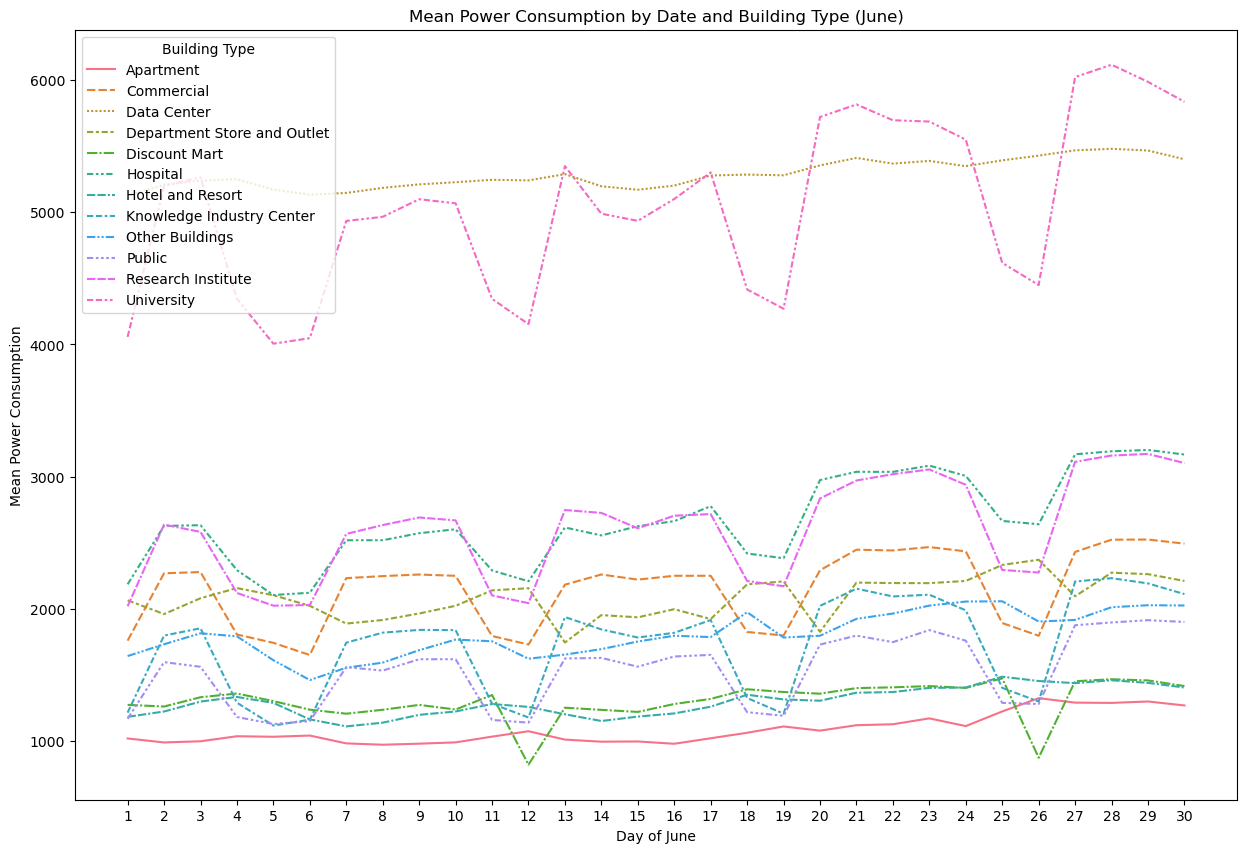

In [25]:
# Ïö∞ÏÑ† Îç∞Ïù¥ÌÑ∞Îäî 6~8ÏõîÍπåÏßÄ Ï†ïÎ≥¥Îßå ÏûàÏñ¥ Í∑∏ ÏÇ¨Ïù¥Îßå ÌôïÏù∏

# 6Ïõî Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
june_data = train_df[train_df['month'] == 6]

# Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ ÎÇ†ÏßúÎ≥Ñ ÌèâÍ∑† Ï†ÑÎ†• ÏÜåÎπÑÎüâ Í≥ÑÏÇ∞
mean_power_by_date_building_type = june_data.groupby(['day', 'building_type'])['power_consumption'].mean().reset_index()

# Pivot ÌÖåÏù¥Î∏î ÏÉùÏÑ±
pivot_df = mean_power_by_date_building_type.pivot(index='day', columns='building_type', values='power_consumption')

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Building Type (June)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.xticks(range(1, 31))  # 6ÏõîÏùÄ 30ÏùºÍπåÏßÄ ÏûàÏúºÎØÄÎ°ú Î≤îÏúÑÎ•º 1Î∂ÄÌÑ∞ 30ÍπåÏßÄÎ°ú ÏÑ§Ï†ï
plt.show()

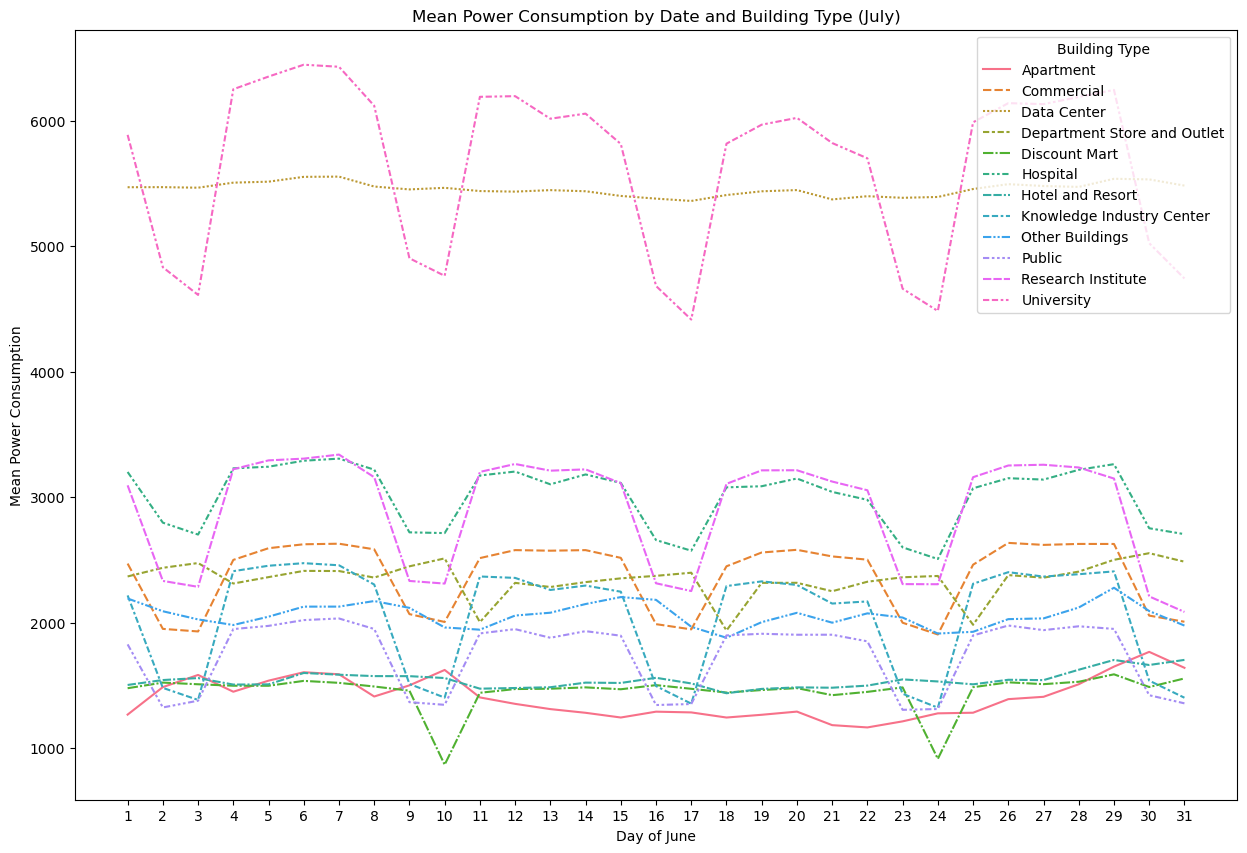

In [26]:
# 7Ïõî Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
July_data = train_df[train_df['month'] == 7]

# Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ ÎÇ†ÏßúÎ≥Ñ ÌèâÍ∑† Ï†ÑÎ†• ÏÜåÎπÑÎüâ Í≥ÑÏÇ∞
mean_power_by_date_building_type = July_data.groupby(['day', 'building_type'])['power_consumption'].mean().reset_index()

# Pivot ÌÖåÏù¥Î∏î ÏÉùÏÑ±
pivot_df = mean_power_by_date_building_type.pivot(index='day', columns='building_type', values='power_consumption')

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Building Type (July)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.xticks(range(1, 32))  # 7ÏõîÏùÄ 31ÏùºÍπåÏßÄ ÏûàÏúºÎØÄÎ°ú Î≤îÏúÑÎ•º 1Î∂ÄÌÑ∞ 31ÍπåÏßÄÎ°ú ÏÑ§Ï†ï
plt.show()

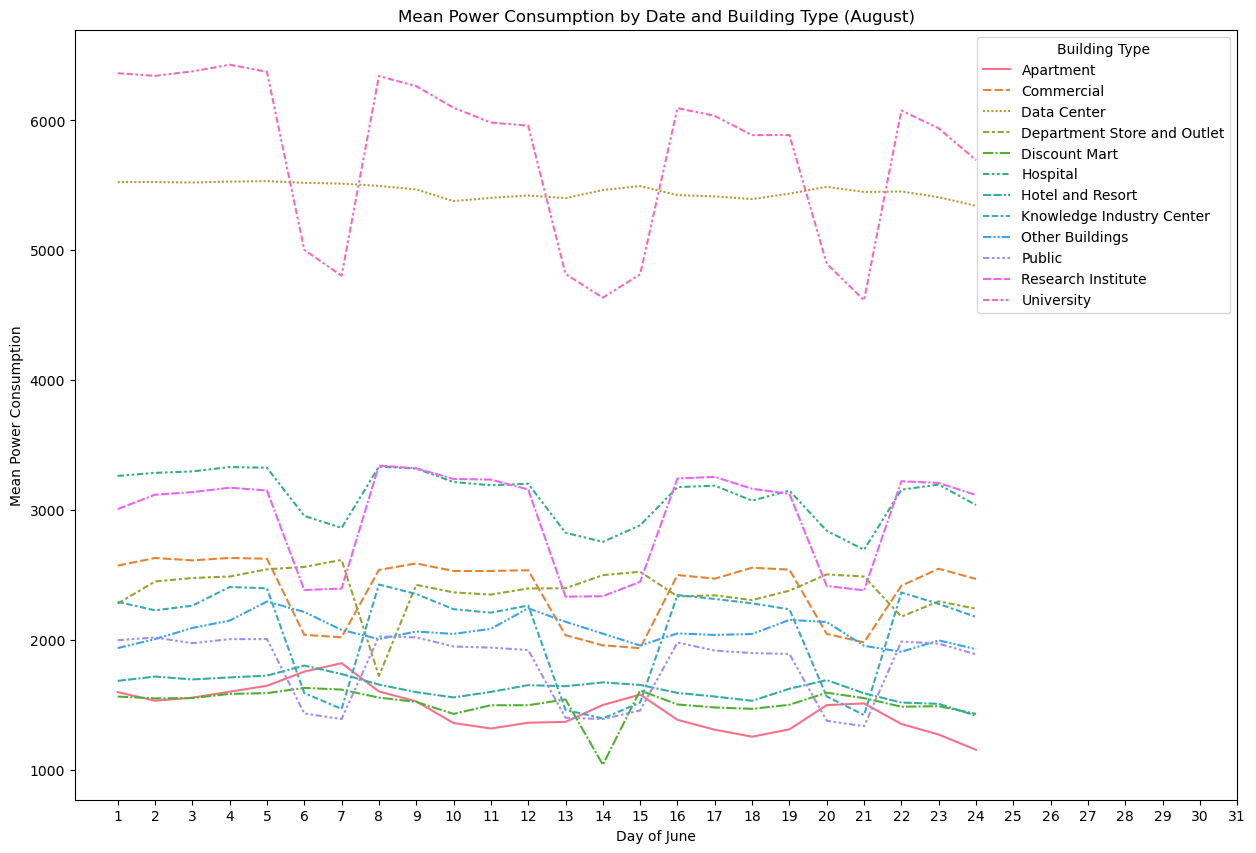

In [27]:
# 8Ïõî Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
Aug_data = train_df[train_df['month'] == 8]

# Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ ÎÇ†ÏßúÎ≥Ñ ÌèâÍ∑† Ï†ÑÎ†• ÏÜåÎπÑÎüâ Í≥ÑÏÇ∞
mean_power_by_date_building_type = Aug_data.groupby(['day', 'building_type'])['power_consumption'].mean().reset_index()

# Pivot ÌÖåÏù¥Î∏î ÏÉùÏÑ±
pivot_df = mean_power_by_date_building_type.pivot(index='day', columns='building_type', values='power_consumption')

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Building Type (August)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.xticks(range(1, 32))   # 8ÏõîÏùÄ 31ÏùºÍπåÏßÄ ÏûàÏúºÎØÄÎ°ú Î≤îÏúÑÎ•º 1Î∂ÄÌÑ∞ 31ÍπåÏßÄÎ°ú ÏÑ§Ï†ï
plt.show()

 - Í∑∏ÎûòÌîÑÎ•º Î≥¥Î©¥ ÏïÑÌååÌä∏ÎÇò Îç∞Ïù¥ÌÑ∞ÏÑºÌÑ∞ Ìò∏ÌÖî Î¶¨Ï°∞Ìä∏Î•º Ï†úÏô∏Ìïú ÎπåÎî© ÌÉÄÏûÖÏóêÏÑú Ïù¥ÏÉÅÏπò Î∞úÍ≤¨, Í≥µÌÜµÏúºÎ°ú Î∞úÍ≤¨ÎêòÎäî Ïù¥ÏÉÅÏπòÎäî Í≥µÌú¥ÏùºÎ°ú Ï∂îÏ∏°ÌïòÍ≥† Í∑∏ Ïô∏Ïùò Ïù¥ÏÉÅÏπòÎäî ÎπåÎî© ÌÉÄÏûÖÎ≥Ñ Ìú¥Î¨¥ÎÇ†ÏßúÎ°ú ÌååÏïÖ

Ï†úÏùº Ïù¥ÏÉÅÏπòÍ∞Ä Ïã¨Ìïú 2Í∞ú ÎπåÎî© Ï†ïÎ≥¥Î•º ÏãúÍ∞ÅÌôî(Discount Mart, Department Store and Outlet)

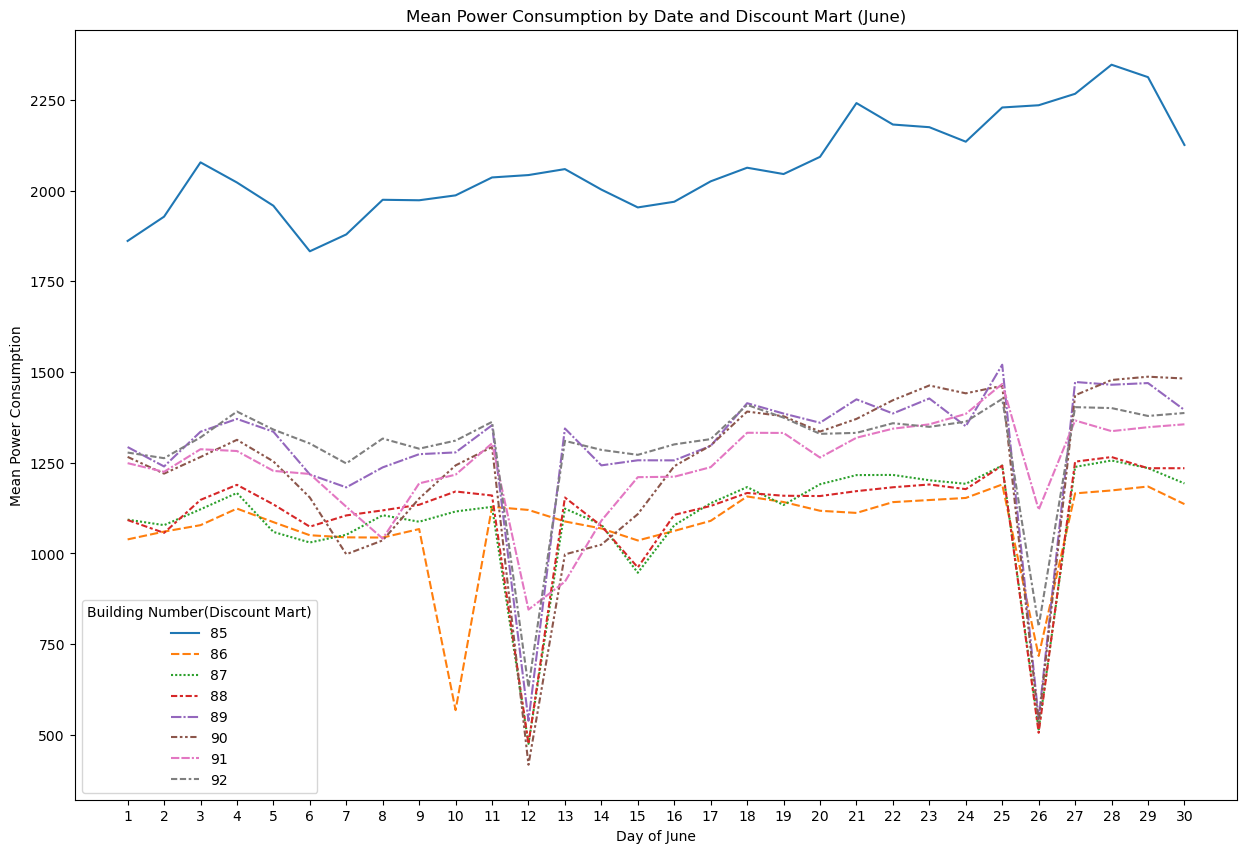

In [35]:
# Discount Mart (6Ïõî) Îç∞Ïù¥ÌÑ∞

# ÌïÑÏöîÌïú Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú (6Ïõî Îç∞Ïù¥ÌÑ∞)
june_data = train_df[(train_df['month'] == 6) & (train_df['building_number'].between(85, 92))]

# Í±¥Î¨º Î≤àÌò∏Î≥Ñ ÎÇ†ÏßúÎ≥Ñ ÌèâÍ∑† Ï†ÑÎ†• ÏÜåÎπÑÎüâ Í≥ÑÏÇ∞
mean_power_by_date_building_number = june_data.groupby(['day', 'building_number'])['power_consumption'].mean().reset_index()

# Pivot ÌÖåÏù¥Î∏î ÏÉùÏÑ±
pivot_df = mean_power_by_date_building_number.pivot(index='day', columns='building_number', values='power_consumption')

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Discount Mart (June)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Number(Discount Mart)')
plt.xticks(range(1, 31))  # 6ÏõîÏùÄ 30ÏùºÍπåÏßÄ ÏûàÏúºÎØÄÎ°ú Î≤îÏúÑÎ•º 1Î∂ÄÌÑ∞ 30ÍπåÏßÄÎ°ú ÏÑ§Ï†ï
plt.show()

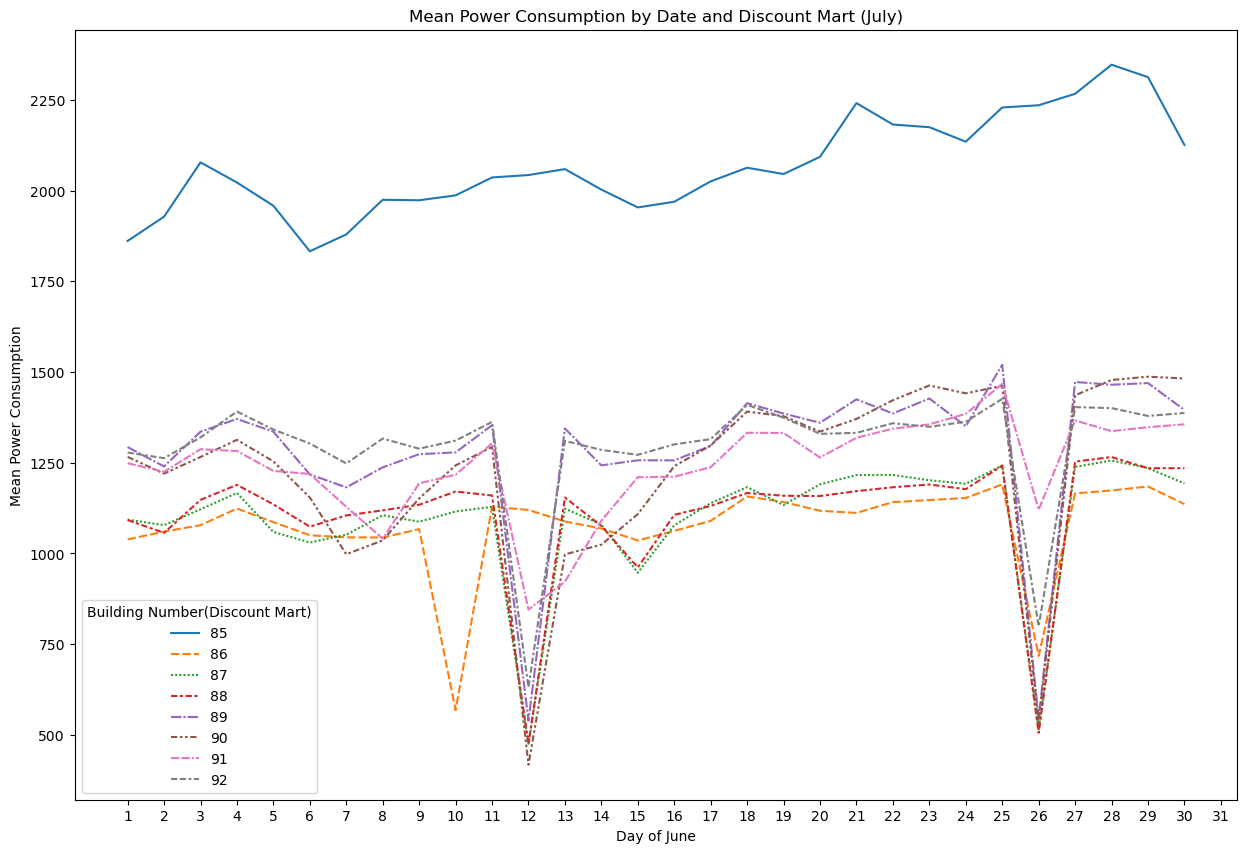

In [37]:
# Discount Mart (7Ïõî) Îç∞Ïù¥ÌÑ∞

# ÌïÑÏöîÌïú Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú (7Ïõî Îç∞Ïù¥ÌÑ∞)
July_data = train_df[(train_df['month'] == 7) & (train_df['building_number'].between(85, 92))]

# Í±¥Î¨º Î≤àÌò∏Î≥Ñ ÎÇ†ÏßúÎ≥Ñ ÌèâÍ∑† Ï†ÑÎ†• ÏÜåÎπÑÎüâ Í≥ÑÏÇ∞
mean_power_by_date_building_number = june_data.groupby(['day', 'building_number'])['power_consumption'].mean().reset_index()

# Pivot ÌÖåÏù¥Î∏î ÏÉùÏÑ±
pivot_df = mean_power_by_date_building_number.pivot(index='day', columns='building_number', values='power_consumption')

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Discount Mart (July)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Number(Discount Mart)')
plt.xticks(range(1, 32))  # 7ÏõîÏùÄ 31ÏùºÍπåÏßÄ ÏûàÏúºÎØÄÎ°ú Î≤îÏúÑÎ•º 1Î∂ÄÌÑ∞ 30ÍπåÏßÄÎ°ú ÏÑ§Ï†ï
plt.show()

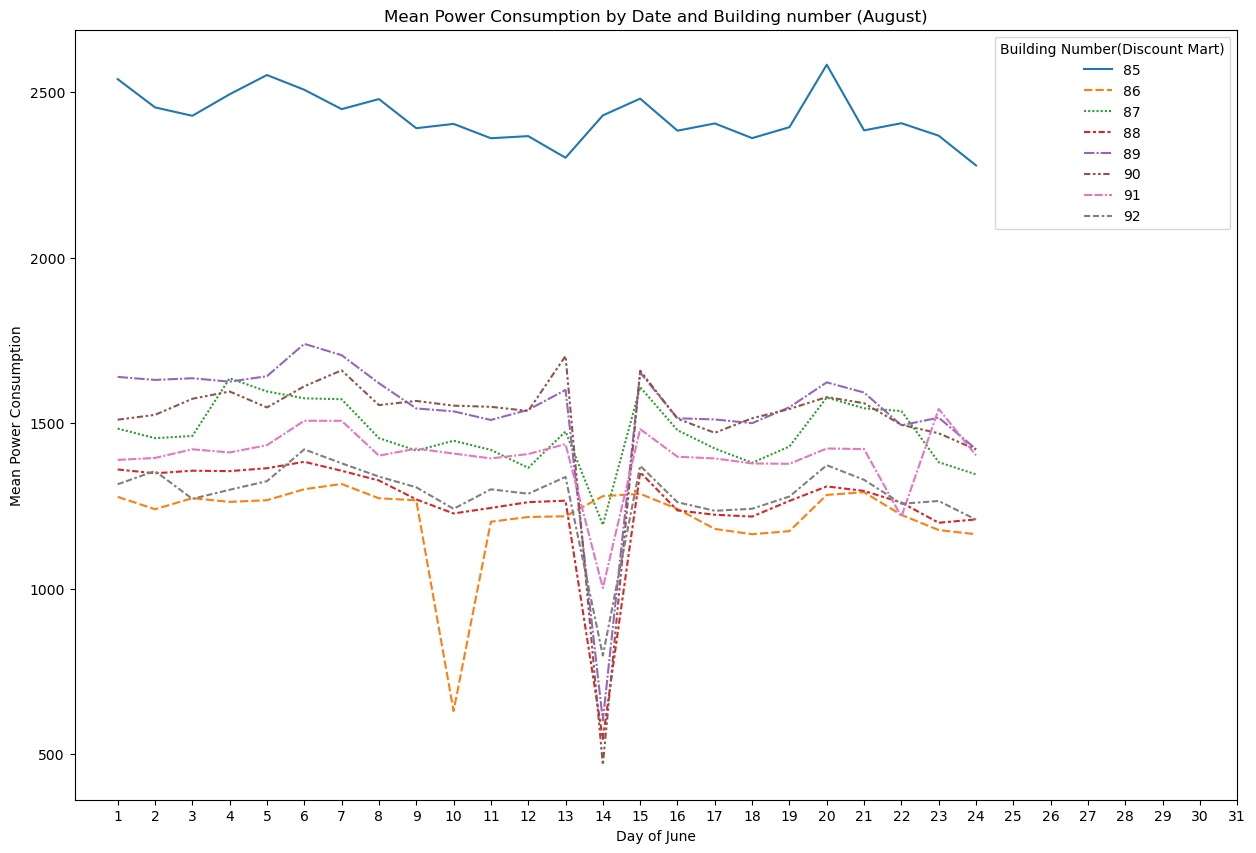

In [39]:
# Discount Mart (7Ïõî) Îç∞Ïù¥ÌÑ∞
# 8Ïõî Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
Aug_data = train_df[(train_df['month'] == 8) & (train_df['building_number'].between(85, 92))]


# Í±¥Î¨º ÌÉÄÏûÖÎ≥Ñ ÎÇ†ÏßúÎ≥Ñ ÌèâÍ∑† Ï†ÑÎ†• ÏÜåÎπÑÎüâ Í≥ÑÏÇ∞
mean_power_by_date_building_type = Aug_data.groupby(['day', 'building_number'])['power_consumption'].mean().reset_index()

# Pivot ÌÖåÏù¥Î∏î ÏÉùÏÑ±
pivot_df = mean_power_by_date_building_type.pivot(index='day', columns='building_number', values='power_consumption')

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Building number (August)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Number(Discount Mart)')
plt.xticks(range(1, 32))   # 8ÏõîÏùÄ 31ÏùºÍπåÏßÄ ÏûàÏúºÎØÄÎ°ú Î≤îÏúÑÎ•º 1Î∂ÄÌÑ∞ 31ÍπåÏßÄÎ°ú ÏÑ§Ï†ï
plt.show()

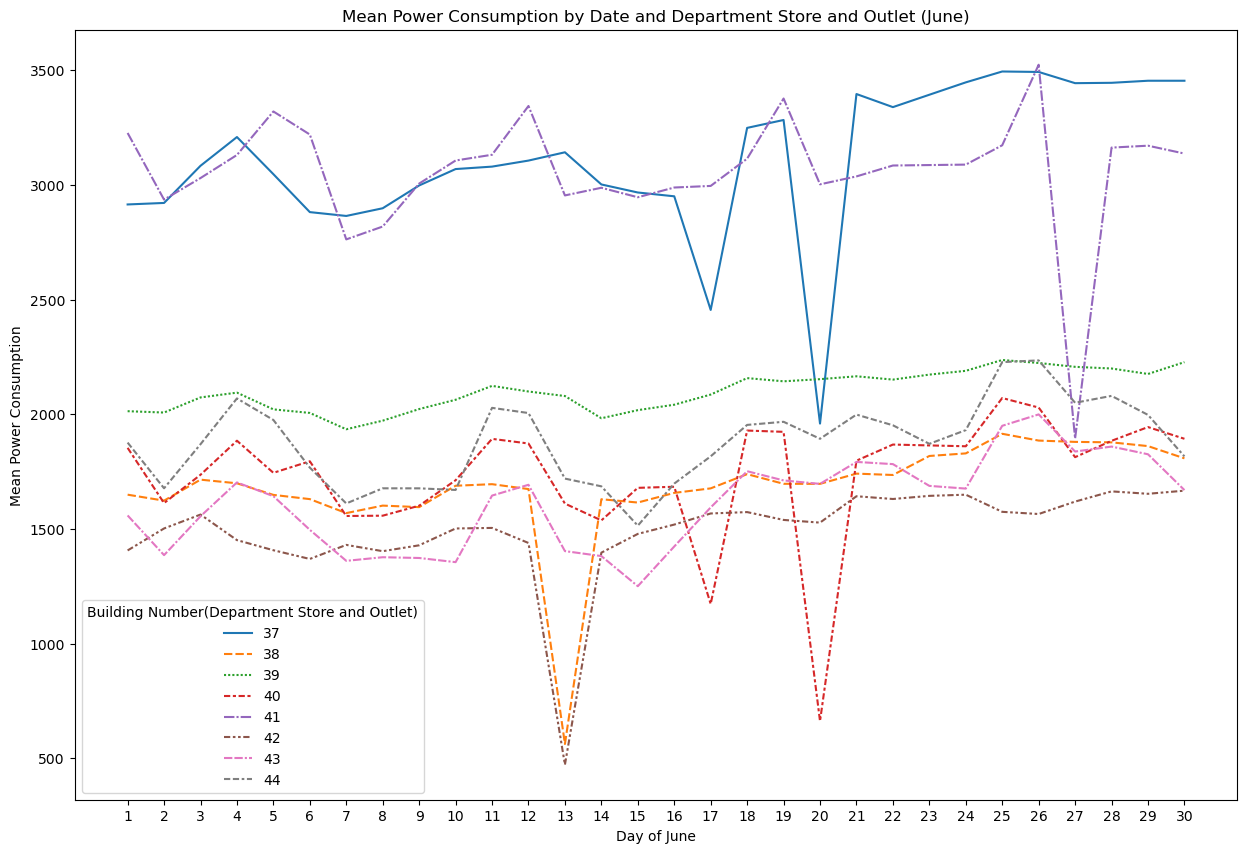

In [40]:
# Department Store and Outlet (6Ïõî) Îç∞Ïù¥ÌÑ∞

# ÌïÑÏöîÌïú Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú (6Ïõî Îç∞Ïù¥ÌÑ∞)
june_data = train_df[(train_df['month'] == 6) & (train_df['building_number'].between(37, 44))]

# Í±¥Î¨º Î≤àÌò∏Î≥Ñ ÎÇ†ÏßúÎ≥Ñ ÌèâÍ∑† Ï†ÑÎ†• ÏÜåÎπÑÎüâ Í≥ÑÏÇ∞
mean_power_by_date_building_number = june_data.groupby(['day', 'building_number'])['power_consumption'].mean().reset_index()

# Pivot ÌÖåÏù¥Î∏î ÏÉùÏÑ±
pivot_df = mean_power_by_date_building_number.pivot(index='day', columns='building_number', values='power_consumption')

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Department Store and Outlet (June)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Number(Department Store and Outlet)')
plt.xticks(range(1, 31))  # 6ÏõîÏùÄ 30ÏùºÍπåÏßÄ ÏûàÏúºÎØÄÎ°ú Î≤îÏúÑÎ•º 1Î∂ÄÌÑ∞ 30ÍπåÏßÄÎ°ú ÏÑ§Ï†ï
plt.show()

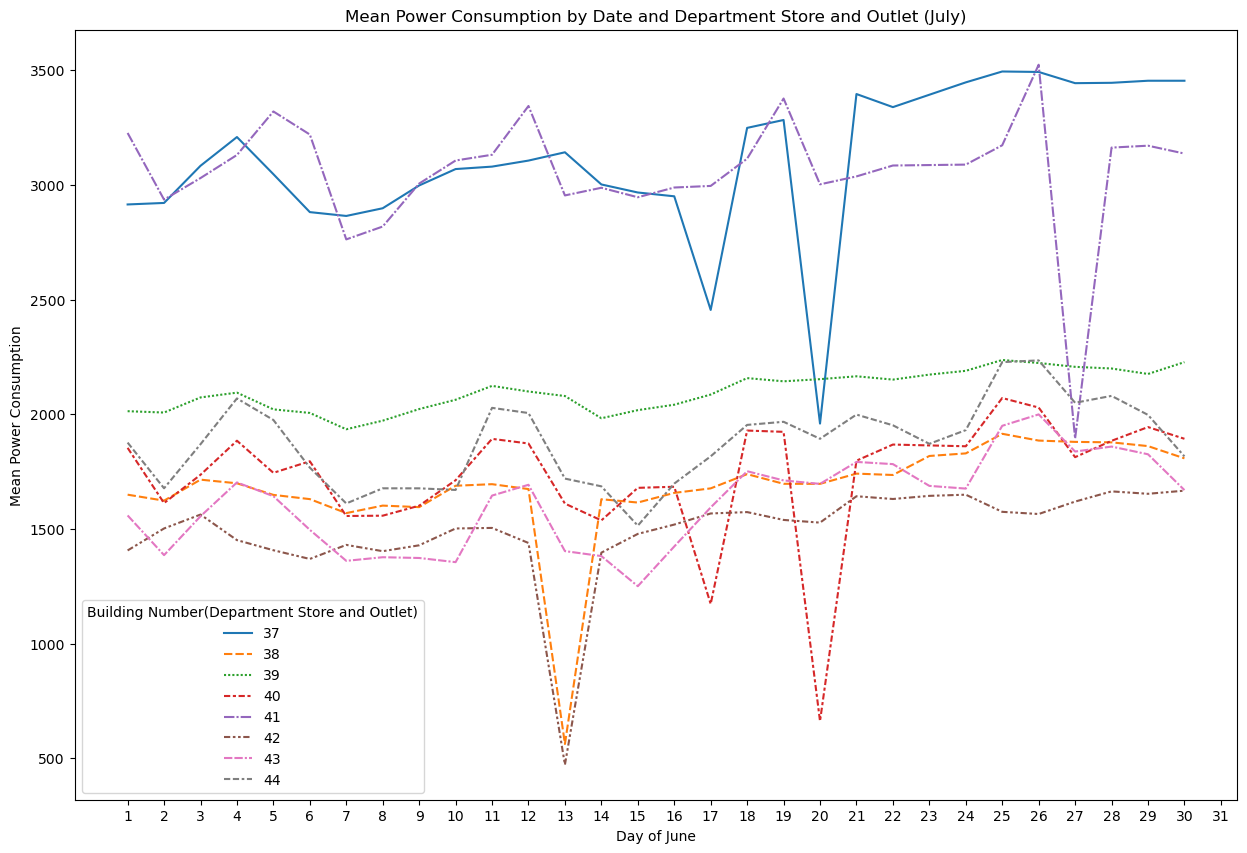

In [42]:
# Department Store and Outlet (7Ïõî) Îç∞Ïù¥ÌÑ∞

# ÌïÑÏöîÌïú Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú (7Ïõî Îç∞Ïù¥ÌÑ∞)
July_data = train_df[(train_df['month'] == 7) & (train_df['building_number'].between(37, 44))]

# Í±¥Î¨º Î≤àÌò∏Î≥Ñ ÎÇ†ÏßúÎ≥Ñ ÌèâÍ∑† Ï†ÑÎ†• ÏÜåÎπÑÎüâ Í≥ÑÏÇ∞
mean_power_by_date_building_number = june_data.groupby(['day', 'building_number'])['power_consumption'].mean().reset_index()

# Pivot ÌÖåÏù¥Î∏î ÏÉùÏÑ±
pivot_df = mean_power_by_date_building_number.pivot(index='day', columns='building_number', values='power_consumption')

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Department Store and Outlet (July)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Number(Department Store and Outlet)')
plt.xticks(range(1, 32))  # 7ÏõîÏùÄ 31ÏùºÍπåÏßÄ ÏûàÏúºÎØÄÎ°ú Î≤îÏúÑÎ•º 1Î∂ÄÌÑ∞ 30ÍπåÏßÄÎ°ú ÏÑ§Ï†ï
plt.show()

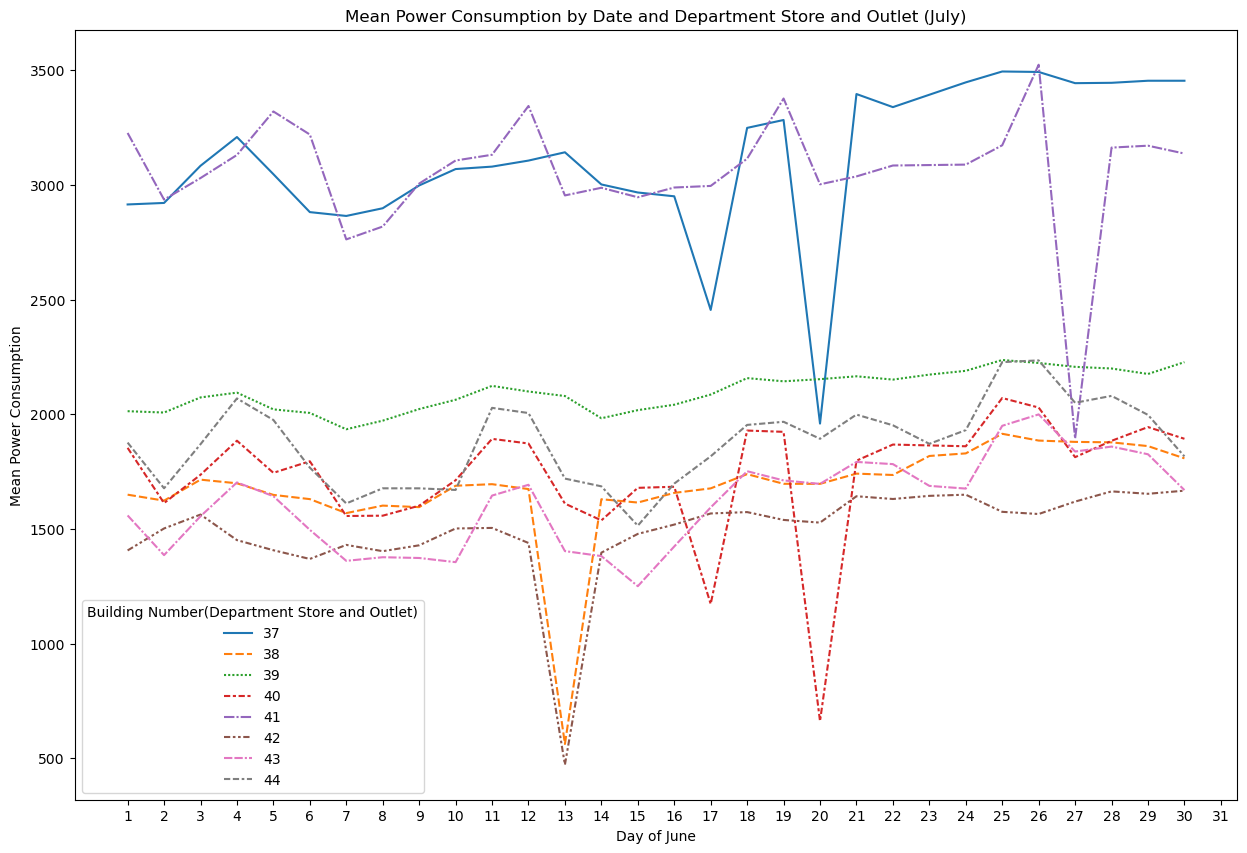

In [43]:
# Department Store and Outlet (8Ïõî) Îç∞Ïù¥ÌÑ∞

# ÌïÑÏöîÌïú Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú (8Ïõî Îç∞Ïù¥ÌÑ∞)
July_data = train_df[(train_df['month'] == 8) & (train_df['building_number'].between(37, 44))]

# Í±¥Î¨º Î≤àÌò∏Î≥Ñ ÎÇ†ÏßúÎ≥Ñ ÌèâÍ∑† Ï†ÑÎ†• ÏÜåÎπÑÎüâ Í≥ÑÏÇ∞
mean_power_by_date_building_number = june_data.groupby(['day', 'building_number'])['power_consumption'].mean().reset_index()

# Pivot ÌÖåÏù¥Î∏î ÏÉùÏÑ±
pivot_df = mean_power_by_date_building_number.pivot(index='day', columns='building_number', values='power_consumption')

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Department Store and Outlet (July)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Number(Department Store and Outlet)')
plt.xticks(range(1, 32))  # 8ÏõîÏùÄ 31ÏùºÍπåÏßÄ ÏûàÏúºÎØÄÎ°ú Î≤îÏúÑÎ•º 1Î∂ÄÌÑ∞ 30ÍπåÏßÄÎ°ú ÏÑ§Ï†ï
plt.show()

```
power_mean = pd.pivot_table(train, values = 'target', index = ['building', 'hour', 'dow'], aggfunc = np.mean).reset_index()  
power_mean.rename(columns={'target': 'dow_hour_mean'}, inplace=True)  
train = pd.merge(train, power_mean, on=['building', 'hour', 'dow'], how='left')  
test = pd.merge(test, power_mean, on=['building', 'hour', 'dow'], how='left')  
```

[ ÎØ∏ÏÖò 3. ]
üéØ ÏïÑÎûòÏùò ÏßàÎ¨∏Ïóê ÎåÄÌïú ÎãµÏùÑ Ï†úÏ∂úÌï¥ Î≥¥ÏïÑÏöî

ÏúÑÏùò ÏΩîÎìúÏóêÏÑú ÏÉùÏÑ±Îêú 'dow_hour_mean'Îäî Ïñ¥Îñ§ ÏùòÎØ∏Ïùò feature Ïù∏ÏßÄ, 'target'Í≥ºÎäî Î¨¥ÏóáÏù¥ Îã§Î•∏ featureÏù∏ÏßÄ ÎßêÎ°ú ÌëúÌòÑÌï¥ Î≥¥ÏÑ∏Ïöî

'dow_hour_mean' featureÎ•º ÏÉùÏÑ±Ìï®ÏúºÎ°úÏÑú ÏòàÏ∏° Î™®Îç∏ Í¥ÄÏ†êÏóêÏÑú Í∏∞ÎåÄÌï† Ïàò ÏûàÎäî Ìö®Í≥ºÎ•º Í∏∞Ïà†Ìï¥ Î≥¥ÏÑ∏Ïöî

- `dow_hour_mean`: ÏöîÏùº('dow')Í≥º ÏãúÍ∞Ñ('hour')Í≥º Í±¥Î¨º('building')Ïóê Îî∞Î•∏ ÌèâÍ∑† Ï†ÑÎ†• ÏÜåÎπÑÎüâ
- `target`: Ìï¥Îãπ ÏãúÍ∞Ñ ÎåÄÏôÄ ÏöîÏùºÏóê Î∞úÏÉùÌïú **Ïã§Ï†ú** Ï†ÑÎ†• ÏÜåÎπÑÎüâ
  > 2Í∞ú featureÏùò Ï∞®Ïù¥Ï†êÏùÄ dow_hour_meanÎäî ÌèâÍ∑†Í∞íÏùÑ Í≥ÑÏÇ∞Ìïú Í≤É
  
  - Í∏∞ÎåÄÌö®Í≥º
      - modelÏù¥ Í∞Å Í±¥Î¨ºÏóê ÎåÄÌï¥ ÌäπÏ†ï ÏãúÍ∞ÑÎåÄÏôÄ ÏöîÏùºÏóê Î∞úÏÉùÌïòÎäî Ï†ÑÎ†• ÏÜåÎπÑÎüâÏùò ÌèâÍ∑†ÏùÑ ÌïôÏäµÌï† Ïàò ÏûàÎã§.
      - Ïù¥Î•º ÌÜµÌï¥ Î™®Îç∏Ïù¥ ÏãúÍ∞ÑÍ≥º ÏöîÏùºÏóê Îî∞Î•∏ Ï†ÑÎ†• ÏÜåÎπÑÎüâÏùò Í≤ΩÌñ•ÏÑ±ÏùÑ ÌïôÏäµÌïòÍ≥†, ÏòàÏ∏° Ïãú Ìï¥Îãπ ÏãúÍ∞ÑÎåÄÏôÄ ÏöîÏùºÏùò Ï†ÑÎ†•ÏÜåÎπÑÎüâÏùÑ Î≥¥Îã§ Ï†ïÌôïÌïòÍ≤å ÏóêÏ∏° Í∞ÄÎä•ÌïòÎã§